# looking for market portfolio and beta

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [23]:
# input the date of data beginning

datebegin = input("Tell me the first date of data (xxxx-x-x): ")
dateend = pd.datetime.now()

In [24]:
#first we create a nan set for future data input

dateindex = pd.date_range(datebegin, dateend).astype('str')
nansheet = pd.DataFrame(index=dateindex)
nansheet.head()

""
2020-01-01
2020-01-02
2020-01-03
2020-01-04
2020-01-05


In [25]:
# stock list should be input first
stocklist = ["AAL", "AAP"]

In [26]:
for i in range(len(stocklist)):
    i_data = pd.read_csv(stocklist[i] + ".csv").set_index("Date")
    df = i_data["Adj Close"]
    df.index.name = None
    nansheet[stocklist[i]] = df
    
nansheet.head()

,AAL,AAP
2020-01-01,NaN,NaN
2020-01-02,28.982893,158.410934
2020-01-03,27.548195,158.420868
2020-01-04,NaN,NaN
2020-01-05,NaN,NaN


In [27]:
# 计算各只股票的日收益率
fullsheet = nansheet.copy().dropna(axis=0)
returnsheet = fullsheet.pct_change()
returnsheet.head()

,AAL,AAP
2020-01-02,NaN,NaN
2020-01-03,-0.049502,0.000063
2020-01-06,-0.011935,-0.016435
2020-01-07,-0.003660,-0.011862
2020-01-08,0.022777,-0.011488


In [28]:
# calculate daily mean return and volatility
meanreturn = returnsheet.describe().loc['mean']
vol = returnsheet.describe().loc['std']

In [29]:
# calculate covariance
cov = returnsheet.cov()

In [30]:
# draw efficient frontier
portfolio = pd.DataFrame(index=np.arange(0, 0.02, 0.0001),
                         columns=["min vol"])

for ret in np.arange(0, 0.02, 0.0001):
    fun = lambda x : np.sqrt(np.dot(x, np.dot(cov, x.T))) 
    cons = ({'type': 'eq', 'fun': lambda x: np.dot(x, meanreturn) - ret},
            {'type': 'eq', 'fun': lambda x: sum(x) - 1})
    x0 = np.zeros(len(stocklist))
    x0[0] = 1
    res = minimize(fun, x0, method='SLSQP', constraints=cons)
    portfolio.loc[ret]['min vol'] = res.fun
    
portfolio

,min vol
0.0000,0.0360179
0.0001,0.0351129
0.0002,0.0344898
0.0003,0.034164
0.0004,0.0341441
0.0005,0.0344305
0.0006,0.0350157
0.0007,0.0358852
0.0008,0.0370189
0.0009,0.0383934


(0, 0.004)

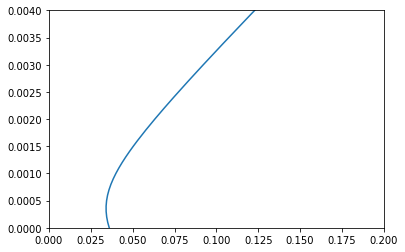

In [31]:
plt.plot(portfolio["min vol"], portfolio.index)
plt.xlim(0, 0.2)
plt.ylim(0, 0.004)

In [32]:
portfolio["sharpe ratio"] = portfolio.index / portfolio['min vol']
max_sharpe = max(portfolio['sharpe ratio'])

In [33]:
max_sharpe
portfolio[portfolio["sharpe ratio"]==max_sharpe]

,min vol,sharpe ratio
0.0035,0.107431,0.0325791


In [34]:
fun = lambda x : np.sqrt(np.dot(x, np.dot(cov, x.T))) 
cons = ({'type': 'eq', 'fun': lambda x: np.dot(x, meanreturn) - 0.0015},
            {'type': 'eq', 'fun': lambda x: sum(x) - 1})
x0 = np.zeros(len(stocklist))
x0[0] = 1
res = minimize(fun, x0, method='SLSQP', constraints=cons)
weight = res.x

weight

array([-0.50447089,  1.50447089])

In [35]:
# calculate beta & alpha
market_sheet = returnsheet.copy()
m, n = market_sheet.shape
market_sheet['market portfolio'] = np.nan
marketreturn = []
for i in range(m):
    marketreturn.append(sum(market_sheet.iloc[i, : n].copy()*weight))
    # marketreturn = sum(stockreturn*weight)
market_sheet["market portfolio"] = marketreturn
market_sheet.tail()

,AAL,AAP,market portfolio
2020-08-31,-0.039735,0.009950,0.035015
2020-09-01,0.003831,0.000512,-0.001163
2020-09-02,0.009924,0.010934,0.011444
2020-09-03,0.009826,-0.018469,-0.032744
2020-09-04,0.018713,-0.009215,-0.023304


In [36]:
betamat = market_sheet.cov()/(market_sheet["market portfolio"].var())
beta = betamat.loc["market portfolio"]
beta

AAL                -0.523942
AAP                 0.489000
market portfolio    1.000000
Name: market portfolio, dtype: float64

# Finding alpha of each stock
 

we can use the last one year data to get the mean return of market portfolio. According the equation
$\alpha = (r_i - r_f) - \beta[E(r_m) - r_f]$


In [37]:
df1 = market_sheet.copy()
# df1.head()

In [38]:
df2col = df1.columns.tolist()
for i in range(n):
    df2col.insert(2*i+1, df2col[2*i]+" alpha")

df2 = df1.reindex(columns=df2col).copy()
# df2.head()

# set daily risk free rate
rf = 0.8% / 365 ~= 0.000022 = 0
rm = 0.0035

In [44]:
df2["AAL alpha"] = df2["AAL"] - beta[0] * 0.0035
df2["AAP alpha"] = df2["AAP"] - beta[1] * 0.0035
df2

,AAL,AAL alpha,AAP,AAP alpha,market portfolio
2020-01-02,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.049502,-0.047668,0.000063,-0.001649,0.025066
2020-01-06,-0.011935,-0.010101,-0.016435,-0.018146,-0.018705
2020-01-07,-0.003660,-0.001827,-0.011862,-0.013574,-0.016000
2020-01-08,0.022777,0.024611,-0.011488,-0.013200,-0.028775
2020-01-09,0.003951,0.005785,-0.001893,-0.003605,-0.004842
2020-01-10,-0.022540,-0.020706,-0.025250,-0.026962,-0.026618
2020-01-13,0.002562,0.004396,-0.025166,-0.026877,-0.039154
2020-01-14,0.005111,0.006945,0.025059,0.023347,0.035121
2020-01-15,0.001816,0.003650,0.008798,0.007086,0.012320


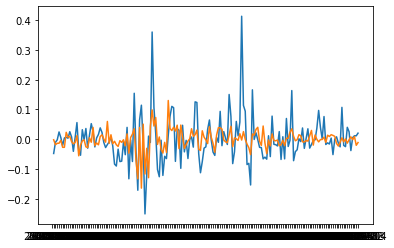

In [47]:
plt.plot(df2.index, df2["AAL alpha"])
plt.plot(df2.index, df2["AAP alpha"])